# ML2 | Pollution Prediction Project
**MAI 2023/24 USC | Online Learning Project**

This Jupyter Notebook is part of the Online Learning Project for the Machine Learning 2 course at USC School. The project is uses data from the [Data Repository](https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate). 


**Authors:**
- Brian García Machado
- Fernando Núnez Sánchez
- Marcin Jedrzejowski 
- Santiago Suárez Carrera


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Problem description (Max 1 point)

### Informal Problem Description
Predicting pollution levels (PM2.5) is crucial for public health and environmental policy-making. This project aims to forecast pollution levels 24 hours ahead using weather forecasts and current pollution data.

### ML Problem Characteristics
- **What is the problem?** Time series forecasting of pollution levels 24 hours ahead.
- **Type of problem:** Regression.
- **Potential for concept drift:** Consider how seasonal changes, urban development, or policy changes may affect pollution levels over time.
- **Evaluation metrics:** Use MAE for model performance evaluation due to the regression nature of the problem.

## 2. Dataset Selection (Max. 1 point)
- **Justification for Dataset Suitability:** The selected dataset is ideal for stream learning due to its temporal component and relevance to pollution level predictions.
- **Dataset Source:** Confirm the source of the dataset and its suitability for stream processing.
- **Dataset Preparation:** Describe any preprocessing to make the dataset stream-friendly or simulate real-time streaming.

### Dataset Overview

For this project, we have chosen a comprehensive dataset on air pollution, specifically focusing on PM2.5 particle measurements. The dataset comprises several weather-related features alongside the pollution readings, recorded hourly. Our primary goal is to predict future pollution levels (24 hours ahead) based on current weather conditions and pollution data. This predictive model could serve as a tool for early warning systems to mitigate the adverse effects of air pollution on health and the environment.

### Dataset Characteristics

The dataset includes the following features:

- `date`: Timestamp of the observation (hourly data)
- `pollution`: PM2.5 concentration
- `dew`: Dew point
- `temp`: Temperature
- `press`: Pressure
- `wnd_dir`: Wind direction
- `wnd_spd`: Wind speed
- `snow`: Snowfall
- `rain`: Rainfall

#### Initial Data Analysis


In [2]:
# Loading the dataset
dataset = pd.read_csv('data/air_pollution_dataset.csv')
dataset.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
dataset.size

394200

In [4]:
# Checking for null values
dataset.isnull().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [5]:
# Statistical summary of the dataset
dataset.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [6]:
# Unique values in 'wnd_dir' column
print(dataset['wnd_dir'].unique())


['SE' 'cv' 'NW' 'NE']


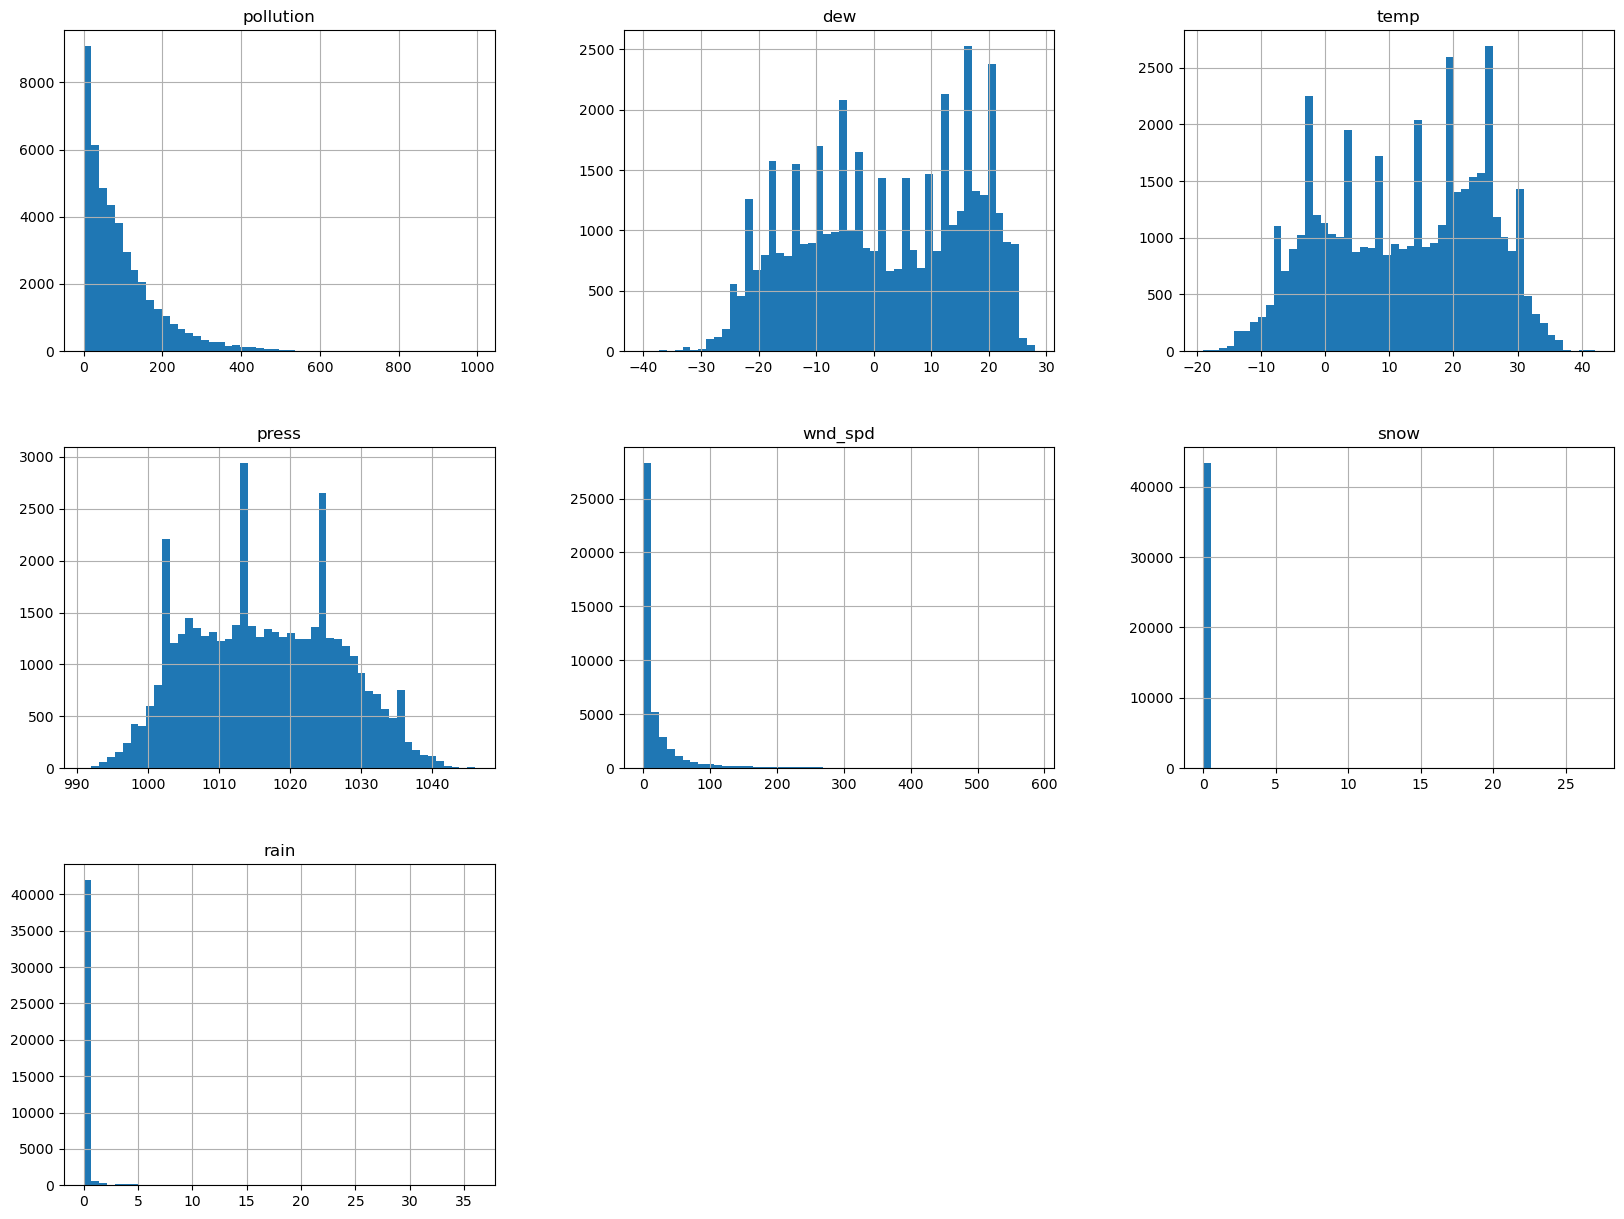

In [7]:
# Data distribution
dataset.hist(bins=50, figsize=(20,15))
plt.show()

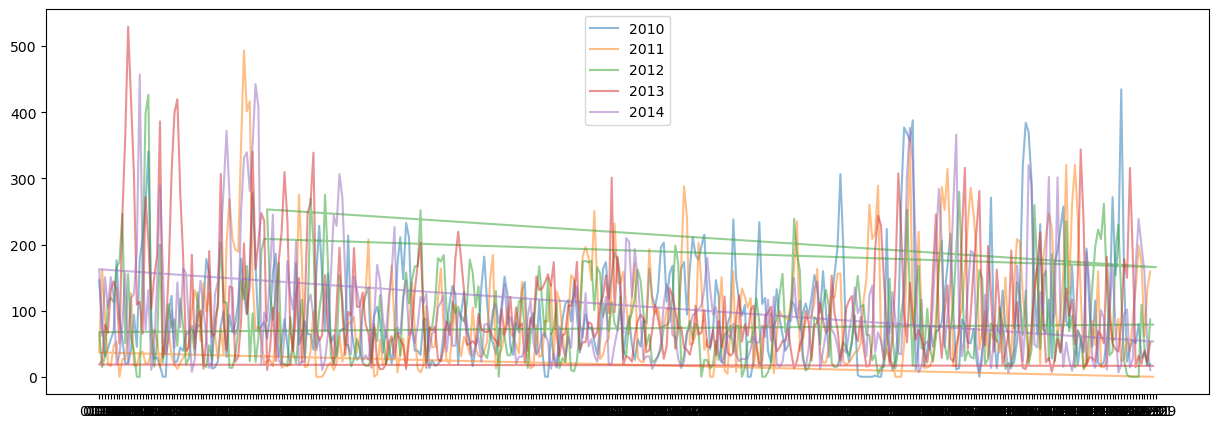

In [8]:
df = pd.read_csv('data/air_pollution_dataset.csv')

# Asegúrate de que la columna 'date' esté en formato datetime
df['date'] = pd.to_datetime(df['date'])

# Establece la columna 'date' como índice
df.set_index('date', inplace=True)

# Crea una nueva columna 'month-day' que contiene solo el mes y el día de cada fecha
df['month-day'] = df.index.strftime('%m-%d')

# Crea una nueva columna 'year' que contiene solo el año de cada fecha
df['year'] = df.index.year

# Agrupa por 'year' y 'month-day' y calcula la media de la contaminación para cada grupo
df_grouped = df.groupby(['year', 'month-day'])['pollution'].mean().reset_index()

# Crea un gráfico para cada año
plt.figure(figsize=(15, 5))
for year in df_grouped['year'].unique():
    df_year = df_grouped[df_grouped['year'] == year]
    plt.plot(df_year['month-day'], df_year['pollution'], label=year, alpha=0.5)

plt.legend()
plt.show()

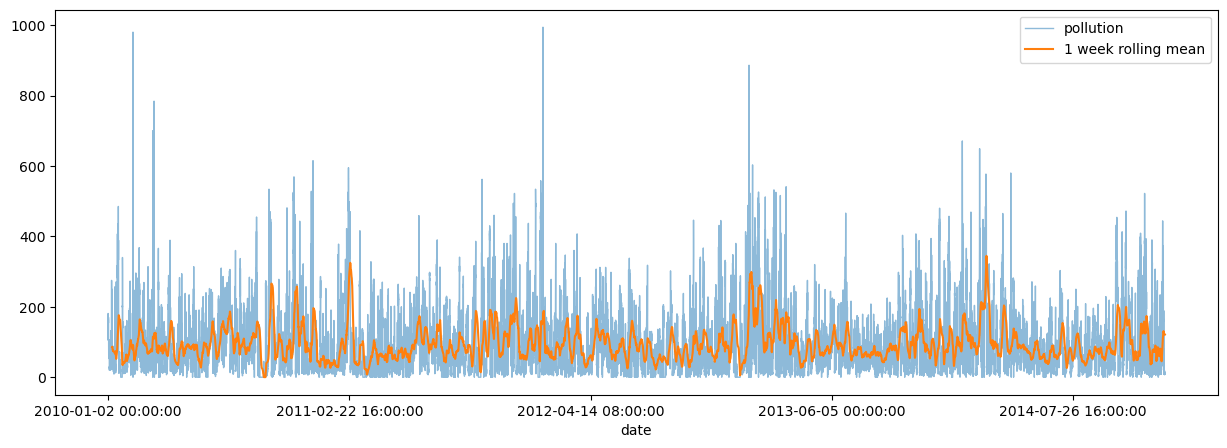

In [9]:
# Plotting the pollution data and its 1 week rolling mean
dataset.plot(x='date', y='pollution', linewidth=1, alpha=0.5, figsize=(15, 5))
dataset['pollution'].rolling(window=168).mean().plot(figsize=(15, 5), label='1 week rolling mean')
plt.legend()

## 3. Data Preparation (Max. 1 point)
- **Data Type Conversions:** Convert categorical variables and cast numerical variables as needed for River processing.
- **Normalization/Standardization:** Discuss normalizing or standardizing features to improve model performance.
- **Feature Engineering:** Create new features and select relevant ones to enhance predictions.
- **Categorization:** Explain categorization of continuous variables, if applicable.


### Feature Engineering

To align with our objective, we will perform the following data preparation steps:

1. **Shift the `pollution` column by 24 hours** to create the `current_pollution` variable.
2. **Forecast Weather Features**: For the purpose of this project, we will treat the weather features as if they were forecasts for the next 24 hours, at thte time of the pollution to be prediction. This simplification assumes the availability of accurate weather forecasts.
3. **Encode the `wnd_dir` categorical variable** using one-hot encoding to convert it into a format suitable for our machine learning models.
4. **Normalize or standardize the numerical features** as required to ensure consistent scale across all input features.

These preparation steps will transform the raw dataset into a structured format that our machine learning models can efficiently process to predict future pollution levels.

In [10]:
# Loading the dataset
dataset = pd.read_csv('data/air_pollution_dataset.csv')

In [11]:
# Step 1: Create target variable by shifting pollution
hours_shifted = 24
dataset['current_pollution'] = dataset['pollution'].shift(hours_shifted)

# Rename the pollution column to pred_pollution
dataset = dataset.rename(columns={'pollution': 'pred_pollution'})

# Drop the last 24 rows where pollution_24 is NaN due to shifting
dataset = dataset.iloc[hours_shifted:]
dataset = dataset.reset_index(drop=True)

In [12]:
dataset.head()

,date,pred_pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,current_pollution
0,2010-01-03 00:00:00,90.0,-7,-6.0,1027.0,SE,58.56,4,0,129.0
1,2010-01-03 01:00:00,63.0,-8,-6.0,1026.0,SE,61.69,5,0,148.0
2,2010-01-03 02:00:00,65.0,-8,-7.0,1026.0,SE,65.71,6,0,159.0
3,2010-01-03 03:00:00,55.0,-8,-7.0,1025.0,SE,68.84,7,0,181.0
4,2010-01-03 04:00:00,65.0,-8,-7.0,1024.0,SE,72.86,8,0,138.0


In [13]:
dataset.to_csv('data/air_pollution_dataset_modified.csv', index=False)

In [14]:
# Perform one-hot encoding on the 'wnd_dir' column
dataset = pd.get_dummies(dataset, columns=['wnd_dir'])

In [15]:
# Rename pollution as pred_pollution for clarity
dataset.rename(columns={'pollution': 'pred_pollution'}, inplace=True)

# Rearrange the columns
dataset = dataset[['date', 'current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_cv', 'snow', 'rain', 'pred_pollution']]

dataset.head()

,date,current_pollution,dew,temp,press,wnd_spd,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv,snow,rain,pred_pollution
0,2010-01-03 00:00:00,129.0,-7,-6.0,1027.0,58.56,False,False,True,False,4,0,90.0
1,2010-01-03 01:00:00,148.0,-8,-6.0,1026.0,61.69,False,False,True,False,5,0,63.0
2,2010-01-03 02:00:00,159.0,-8,-7.0,1026.0,65.71,False,False,True,False,6,0,65.0
3,2010-01-03 03:00:00,181.0,-8,-7.0,1025.0,68.84,False,False,True,False,7,0,55.0
4,2010-01-03 04:00:00,138.0,-8,-7.0,1024.0,72.86,False,False,True,False,8,0,65.0


## 4. Concept Drifts (Max. 1 point)
- **Implemented Detectors:** Use at least two concept drift detectors from River to monitor drifts in pollution levels.

In the realm of stream learning, concept drift is a critical aspect to monitor and manage. Concept drift occurs when the statistical properties of the target variable, which the model is trying to predict, change over time. This can significantly impact the performance of machine learning models, making it crucial to detect and adapt to these changes promptly.

### Implemented Detectors

For this project, we will implement two concept drift detectors from the River library to monitor potential drifts in pollution levels:

1. **ADWIN (Adaptive Windowing):** ADWIN is a change detector that automatically adjusts the size of the window by cutting the window at different points depending on the data's variance. This method helps in detecting changes in the average of a stream without needing to define a window size a priori.

2. **Page-Hinkley:** The Page-Hinkley test is a sequential analysis technique used to detect changes in the average of a Gaussian signal. It is particularly useful for detecting abrupt changes in streams.

### Monitoring Concept Drift

By implementing these detectors, we aim to monitor the stream of pollution data for any significant changes that could indicate concept drift. Detecting such drifts allows us to update or retrain our models to maintain high accuracy and relevance despite the changing dynamics of air pollution.

#### ADWIN Implementation

<div style="background-color:#f5f5f5; padding:15px; border-radius:5px; width:94%;">

```python
from river import drift
from river import stream

adwin_detector = drift.ADWIN()
for i, (x, y) in enumerate(stream.iter_sklearn_dataset(dataset)):
    prediction = model.predict_one(x)
    adwin_detector.update(y - prediction)
    if adwin_detector.change_detected:
        print(f"Change detected at index {i}, retraining the model...")
        # Code to retrain the model
```

</div>


### Page-Hinkley Implementation

<div style="background-color:#f5f5f5; padding:15px; border-radius:5px; width:94%;">

```python
ph_detector = drift.PageHinkley()
for i, (x, y) in enumerate(stream.iter_sklearn_dataset(dataset)):
    prediction = model.predict_one(x)
    ph_detector.update(y - prediction)
    if ph_detector.change_detected:
        print(f"Change detected at index {i}, retraining the model...")
        # Code to retrain the model
```

</div>

By employing these concept drift detectors, we ensure our model remains adaptive and responsive to the evolving patterns of air pollution, thereby maintaining its predictive performance over time.


## 5. Batch Learning with Base Model (Max. 1 point)
- **Data Splitting:** Ensure temporal integrity when splitting the dataset.
- **Model Training and Evaluation:** Train a base model, evaluate its performance, and establish a benchmark for stream learning models.

To establish a benchmark for our stream learning models, we'll start with a traditional batch learning approach using a base model. For consistency and comparability, we'll select a model that is also available in River, allowing for a direct comparison between batch and online learning performances later on. In this case, we'll use a RandomForestRegressor as our base model due to its versatility and strong performance across a variety of regression tasks.

### Model Training and Evaluation
We'll split our prepared dataset into training and testing sets, train a RandomForestRegressor on the training set, and evaluate its performance on the testing set. The performance metrics of interest will be Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), which are commonly used in regression tasks to quantify the prediction error of a model.

#### Data preparation

### With cross-validation. 

In [16]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Drop the date column and prepare features and target
bash_dataset = dataset.drop(columns='date')
X = bash_dataset.drop(columns=['pred_pollution'])
y = bash_dataset['pred_pollution'].values

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Define the MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mae_bl_results = {}

# Define a deterministic cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define transformer for scaling
columns_to_scale = ['current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Keep the one-hot encoded 'wnd_dir' columns as is
)

#### Random Forest Regressor

In [17]:
# Initialize the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Perform cross-validation and calculate scores
scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['Random Forest Regressor'] = scores

# Display results
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 39.0316 (± 0.3901)


### Linear Regression

In [18]:
# Initialize the LinearRegression model
model = LinearRegression()

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])
scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['Linear Regression'] = scores
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 54.4235 (± 0.6271)


### Decision Tree Regressor

In [19]:
# Initialize the DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['Decision Tree Regressor'] = scores
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 50.5114 (± 0.2397)


### KNN Regressor

In [20]:
# Initialize the KNeighborsRegressor model
model = KNeighborsRegressor(n_neighbors=5)

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['KNeighbors Regressor'] = scores
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 41.4259 (± 0.4366)


In [21]:
mae_bl_results

{'Random Forest Regressor': array([-39.1219002 , -39.20220691, -38.69515283, -39.62050233,
        -38.51814188]),
 'Linear Regression': array([-54.31692492, -54.40172804, -54.77876898, -55.25944609,
        -53.36076965]),
 'Decision Tree Regressor': array([-50.42867748, -50.40062821, -50.37327242, -50.98874929,
        -50.36561965]),
 'KNeighbors Regressor': array([-41.96295112, -41.37628784, -41.14601942, -41.85229012,
        -40.79175328])}

### Metric comparison

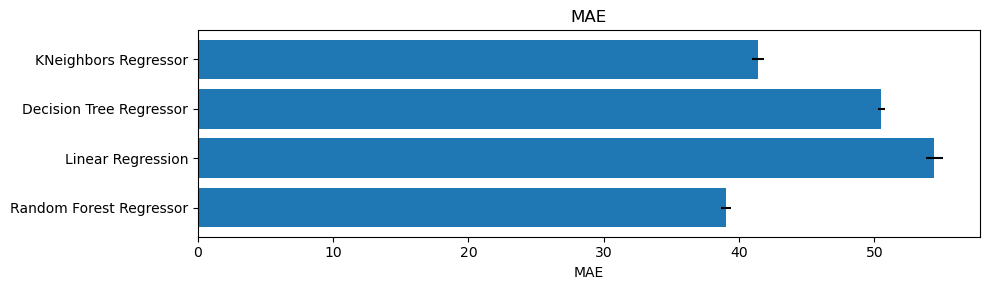

In [22]:
# Plot the scores comparing the different models
plt.figure(figsize=(10, 3))
plt.barh(list(mae_bl_results.keys()), [-score.mean() for score in mae_bl_results.values()], xerr=[score.std() for score in mae_bl_results.values()])
plt.title('MAE')
plt.xlabel('MAE')
plt.tight_layout()
plt.show()

## 6. Stream Learning (Max. 2 points)
- **Stream Pipeline Implementation:** Develop a River stream pipeline for data preprocessing, model training, and evaluation.
- **Model Selection/Comparison:** Compare at least three machine learning models within River, including a Hoeffding Tree model.

For the Stream Learning section with River, we will implement a stream processing pipeline using River to continuously learn and predict pollution levels based on the data transformations we previously discussed. We will compare three different machine learning models provided by River, including a Hoeffding Tree model, to determine the best performer for our online learning scenario.

### Stream Learning Implementation
To start with, we need to adapt our dataset to a streaming format. River provides a convenient way to simulate streaming data from a DataFrame. We will use the iter_pandas method from River's stream module for this purpose.


In [23]:
from river import compose, preprocessing, evaluate, stream, drift, utils
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
from river import linear_model
from river.neighbors import KNNRegressor
from river.metrics import MAE
import itertools

### Baseline Stream Learning Model

In [24]:
dataset_path = 'data/air_pollution_dataset_modified.csv'

# Wind direction mapping
mapping = {'SE': 1, 'cv': 2, 'NW': 3, 'NE': 4}
converter = lambda x: float(mapping[x])

pollution_stream = stream.iter_csv(dataset_path, target='pred_pollution', converters={'pred_pollution': float, 'current_pollution': float, 'dew': float,
                                                                                 'temp': float, 'press': float, 
                                                                                 'wnd_dir': converter, 'wnd_spd': float,
                                                                                 'snow': float, 'rain': float})
sample, target = next(pollution_stream)
print(sample)
print(target)

{'date': '2010-01-03 00:00:00', 'dew': -7.0, 'temp': -6.0, 'press': 1027.0, 'wnd_dir': 1.0, 'wnd_spd': 58.56, 'snow': 4.0, 'rain': 0.0, 'current_pollution': 129.0}
90.0


In [25]:
mae_ol_results = {}

In [26]:
# Discarding date column and scaling the data
to_discard=['date']
model = compose.Pipeline(compose.Discard(*to_discard), KNNRegressor(n_neighbors=5))

# Check the model's samples after preprocessing
for x, y in pollution_stream:
    model.learn_one(x, y)
    transformed_x = model.transform_one(x)
    print("Transformed:", {key: "{:.5f}".format(value) for key, value in transformed_x.items()})
    print("Predicted: ", model.predict_one(x))
    print("True Label: ", y)
    break

mae_ol_results['Baseline KNN Regressor'] = evaluate.progressive_val_score(dataset=pollution_stream, model=model, metric=MAE(), print_every=2500)

Transformed: {'dew': '-8.00000', 'temp': '-6.00000', 'press': '1026.00000', 'wnd_dir': '1.00000', 'wnd_spd': '61.69000', 'snow': '5.00000', 'rain': '0.00000', 'current_pollution': '148.00000'}
Predicted:  63.0
True Label:  63.0


[2,500] MAE: 41.44712
[5,000] MAE: 42.98088
[7,500] MAE: 43.586
[10,000] MAE: 44.87702
[12,500] MAE: 44.082608
[15,000] MAE: 44.891853
[17,500] MAE: 46.033394
[20,000] MAE: 45.96578
[22,500] MAE: 45.769884
[25,000] MAE: 45.172552
[27,500] MAE: 46.648953
[30,000] MAE: 46.750353
[32,500] MAE: 45.976418
[35,000] MAE: 46.089297
[37,500] MAE: 46.992603
[40,000] MAE: 46.322205
[42,500] MAE: 45.745139
[43,774] MAE: 45.807219


# Comparar despois co comparador de modelos de river que pasa a sklearn-format?

# Meter moving average, 

# se non funciona isto poñerlle un shift de 1-2 horas só a predito e o resto de features que sexan valores actuais.

# facer unha gráfica coa evolución temporal da métrica que queiramos e comparala coa métrica do modelo batch.

### Model Selection for Stream Learning

We will implement three different models for our stream learning scenario:

- **Linear Regression** - A baseline model for regression tasks.
- **Random Forest Regressor** - An ensemble method for regression.
- **Hoeffding Tree Regressor** - A decision tree algorithm designed for streaming data.

For each model, we will create a corresponding River pipeline that includes necessary preprocessing steps (if any) and the model itself.

#### Linear Regression

In [27]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', 
                                                                         converters={'current_pollution': float, 'dew': float, 
                                                                                     'temp': float, 'press': float, 'wnd_spd': float, 
                                                                                     'snow': float, 'rain': float, 
                                                                                     'pred_pollution': float, 'date': pd.to_datetime})

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |= linear_model.LinearRegression()

mae_ol_results['Linear Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 9,012,926,252.585665
[5,000] MAE: 7,955,244,846.852292
[7,500] MAE: 8,287,379,982.34797
[10,000] MAE: 6,865,291,961.716601
[12,500] MAE: 5,576,629,259.241904
[15,000] MAE: 4,652,693,306.092072
[17,500] MAE: 3,989,307,081.6378
[20,000] MAE: 3,580,366,631.877223
[22,500] MAE: 3,185,173,013.425955
[25,000] MAE: 3,256,433,102.72212
[27,500] MAE: 3,764,270,633.377617
[30,000] MAE: 3,501,529,466.443572
[32,500] MAE: 3,241,742,325.782237
[35,000] MAE: 3,012,728,648.966429
[37,500] MAE: 3,468,594,165.296984
[40,000] MAE: 3,263,956,105.028524
[42,500] MAE: 3,094,583,419.918902
[43,776] MAE: 3,020,893,106.218896


#### KNN Regressor

In [28]:


# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |= KNNRegressor(n_neighbors=5)

mae_ol_results['KNN Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 35.785527
[5,000] MAE: 37.117083
[7,500] MAE: 39.276376
[10,000] MAE: 40.738242
[12,500] MAE: 40.218545
[15,000] MAE: 40.789468
[17,500] MAE: 42.38343
[20,000] MAE: 42.573011
[22,500] MAE: 42.451459
[25,000] MAE: 41.865777
[27,500] MAE: 43.415004
[30,000] MAE: 43.551481
[32,500] MAE: 42.846991
[35,000] MAE: 43.014429
[37,500] MAE: 43.73599
[40,000] MAE: 43.066275
[42,500] MAE: 42.597516
[43,776] MAE: 42.761372


#### HoeffdingTreeRegressor

In [29]:


# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |= HoeffdingTreeRegressor( )

mae_ol_results['HT Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)
model

[2,500] MAE: 37.387078
[5,000] MAE: 43.441324
[7,500] MAE: 45.043592
[10,000] MAE: 48.038938
[12,500] MAE: 47.603668
[15,000] MAE: 48.208401
[17,500] MAE: 49.646842
[20,000] MAE: 50.166142
[22,500] MAE: 49.571474
[25,000] MAE: 49.114359
[27,500] MAE: 51.199155
[30,000] MAE: 51.189193
[32,500] MAE: 50.169848
[35,000] MAE: 50.510574
[37,500] MAE: 51.325464
[40,000] MAE: 50.404441
[42,500] MAE: 49.939196
[43,776] MAE: 50.219067


Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        wnd_dir
      ),
      OneHotEncoder (
        drop_zeros=False
        drop_first=False
      )
    ),
    Pipeline (
      Select (
        current_pollution
        dew
        press
        rain
        snow
        temp
        wnd_spd
      ),
      StandardScaler (
        with_std=True
      )
    )
  ),
  HoeffdingTreeRegressor (
    grace_period=200
    max_depth=inf
    delta=1e-07
    tau=0.05
    leaf_prediction="adaptive"
    leaf_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Squared ()
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    model_selector_decay=0.95
    nominal_attributes=None
    splitter=TEBSTSplitter (
      digits=1
    )
    min_samples_split=5
    binary_split=False
    max_size=500.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
)

#### Hoeffding Adaptive Tree Regressor

In [30]:


# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor()

mae_ol_results['HAT Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 35.575043
[5,000] MAE: 31.329575
[7,500] MAE: 35.126098
[10,000] MAE: 35.707404
[12,500] MAE: 35.389564
[15,000] MAE: 34.749369
[17,500] MAE: 35.587023
[20,000] MAE: 36.539788
[22,500] MAE: 35.736334
[25,000] MAE: 35.42503
[27,500] MAE: 36.790932
[30,000] MAE: 36.510502
[32,500] MAE: 35.633651
[35,000] MAE: 35.921967
[37,500] MAE: 36.340018
[40,000] MAE: 35.57562
[42,500] MAE: 35.284998
[43,776] MAE: 35.435767


#### Hoeffding Adaptive Tree Regressor with tunning

In [31]:


# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor(grace_period = 250,  drift_detector=drift.ADWIN())

mae_ol_results['HAT Regressor with tunning'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 45.57388
[5,000] MAE: 37.212154
[7,500] MAE: 37.843107
[10,000] MAE: 38.211927
[12,500] MAE: 37.081071
[15,000] MAE: 36.72289
[17,500] MAE: 37.32947
[20,000] MAE: 38.529308
[22,500] MAE: 37.589035
[25,000] MAE: 36.982666
[27,500] MAE: 38.50186
[30,000] MAE: 38.186023
[32,500] MAE: 37.145151
[35,000] MAE: 37.17738
[37,500] MAE: 37.732843
[40,000] MAE: 36.792953
[42,500] MAE: 37.031969
[43,776] MAE: 37.146341


#### Debugging example

In [32]:
 
 
model = (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model += (compose.Select('wnd_dir') | preprocessing.OneHotEncoder(drop_zeros=False))
model |= HoeffdingAdaptiveTreeRegressor(grace_period=250) 
 
x, y = next(data_stream)
print(model.debug_one(x))

# Train the model on the first 20 samples from the data stream
for x, y in itertools.islice(data_stream, 20):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    print(model.debug_one(x))

0. Input
--------
current_pollution: 129.00000 (float)
date: 2010-01-03 00:00:00 (str)
dew: -7.00000 (float)
press: 1,027.00000 (float)
rain: 0.00000 (float)
snow: 4.00000 (float)
temp: -6.00000 (float)
wnd_dir: SE (str)
wnd_spd: 58.56000 (float)

1. Transformer union
--------------------
    1.0 ['current_pollution', 'dew', 'press', 'rain', 'snow', 'temp', 'wnd_spd'] | StandardScaler
    ---------------------------------------------------------------------------------------------
    current_pollution: 0.00000 (float)
    dew: 0.00000 (float)
    press: 0.00000 (float)
    rain: 0.00000 (float)
    snow: 0.00000 (float)
    temp: 0.00000 (float)
    wnd_spd: 0.00000 (float)

    1.1 ['wnd_dir'] | OneHotEncoder
    -------------------------------
    wnd_dir_SE: 1 (int)

current_pollution: 0.00000 (float)
dew: 0.00000 (float)
press: 0.00000 (float)
rain: 0.00000 (float)
snow: 0.00000 (float)
temp: 0.00000 (float)
wnd_dir_SE: 1 (int)
wnd_spd: 0.00000 (float)

2. HoeffdingAdaptiveTreeReg

In [33]:


# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor()

results = evaluate.iter_progressive_val_score(dataset=data_stream, model=model, metric=MAE(), step=500, yield_predictions=True)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the generator to a list
results_list = list(results)

# Convert the list to a DataFrame
results_df = pd.DataFrame(results_list)

In [70]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})

model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor(grace_period = 250,  drift_detector=drift.ADWIN())


#def evaluate_model(model, data_stream):
metric = MAE()

dates = []
y_trues = []
y_preds = []

for x, y in data_stream:
    # Store the date
    dates.append(x['date'])
    
    # Obtain the prior prediction and update the model in one go
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    # Update the error metric
    metric.update(y, y_pred)

    # Store the true value and the prediction
    y_trues.append(y)
    y_preds.append(y_pred)

Text(0.5, 1.0, 'MAE: 35.527834')

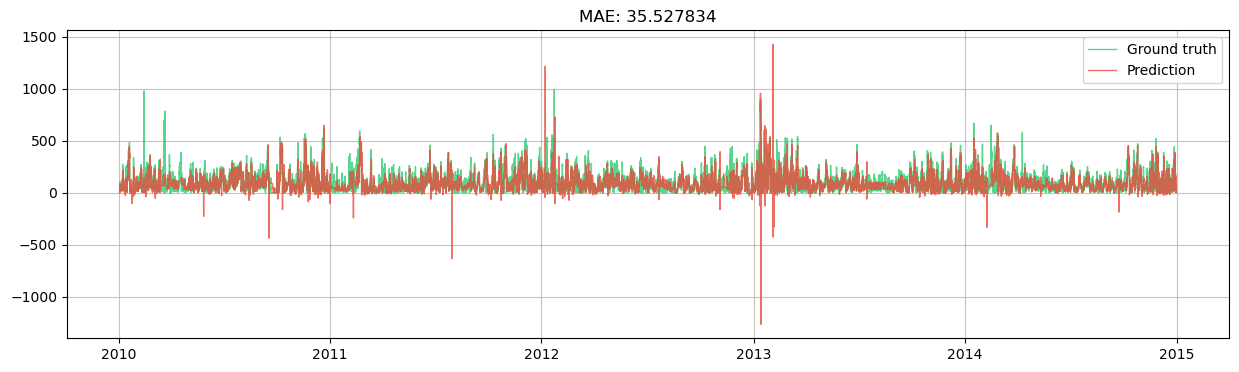

In [71]:
# Plot the results
fig, ax = plt.subplots(figsize=(15, 4))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(str(metric))

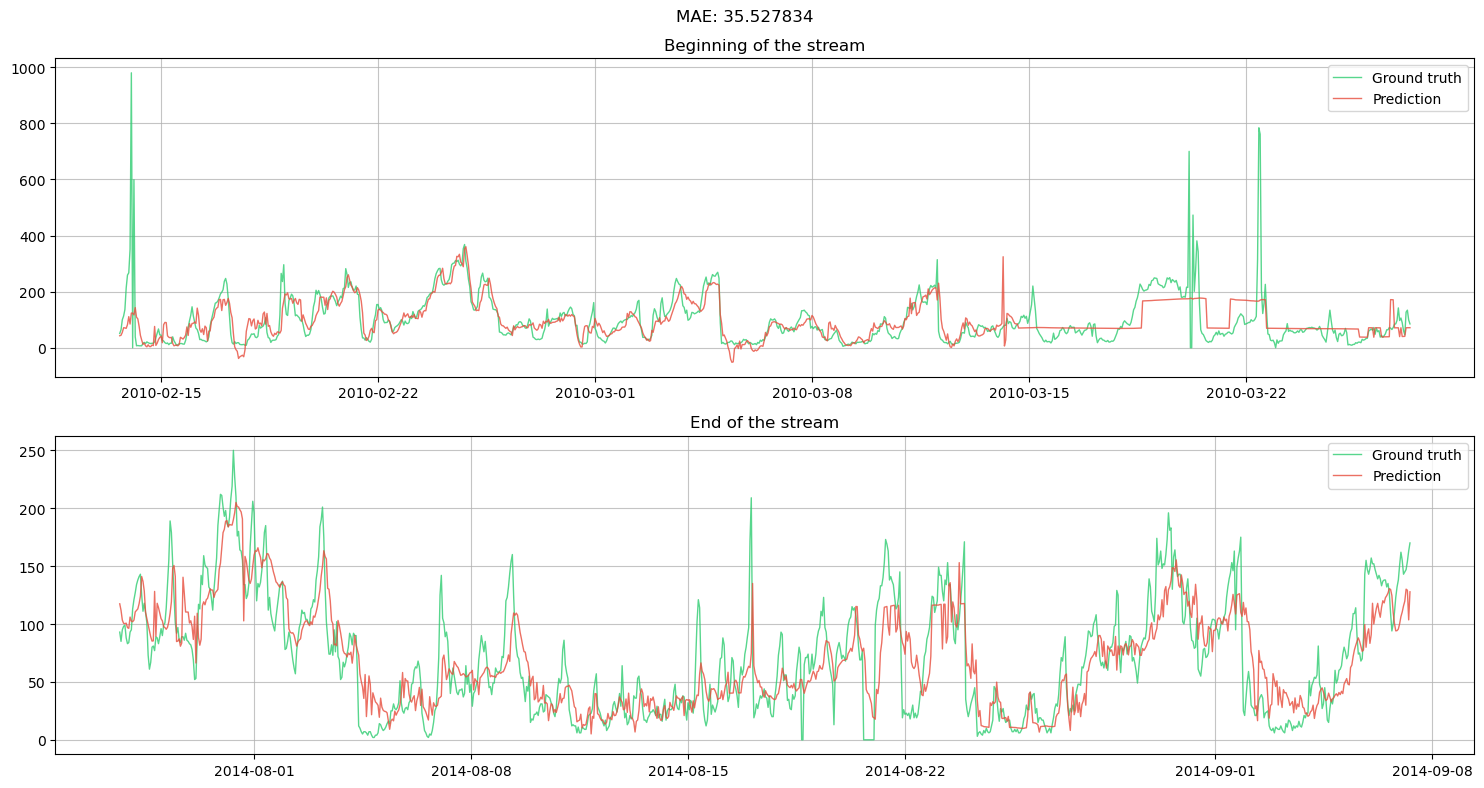

In [72]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
i_top = 1000
i_bottom = 40000
# Plot the ground truth on the first subplot
ax1.grid(alpha=0.75)
ax1.plot(dates[i_top:i_top+1000], y_trues[i_top:i_top+1000], lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(dates[i_top:i_top+1000], y_preds[i_top:i_top+1000], lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
ax1.legend()
ax1.set_title('Beginning of the stream')

# Plot the prediction on the second subplot
ax2.grid(alpha=0.75)
ax2.plot(dates[i_bottom:i_bottom+1000], y_trues[i_bottom:i_bottom+1000], lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(dates[i_bottom:i_bottom+1000], y_preds[i_bottom:i_bottom+1000], lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
ax2.legend()
ax2.set_title('End of the stream')

# Display the metric on the figure title
fig.suptitle(str(metric))

# Adjust the layout
plt.tight_layout()

In [58]:
def evaluate_model(model, data_stream):
    metric = MAE()

    dates = []
    y_trues = []
    y_preds = []

    for x, y in data_stream:
        # Store the date
        dates.append(x['date'])

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)

        # Ensure the prediction is non-negative as pollution can't be negative (jeje)
        y_pred = max(0, y_pred)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.grid(alpha=0.75)
    ax.plot(dates[40000:41000], y_trues[40000:41000], lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates[40000:41000], y_preds[40000:41000], lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(str(metric))
    plt.show()

    return metric

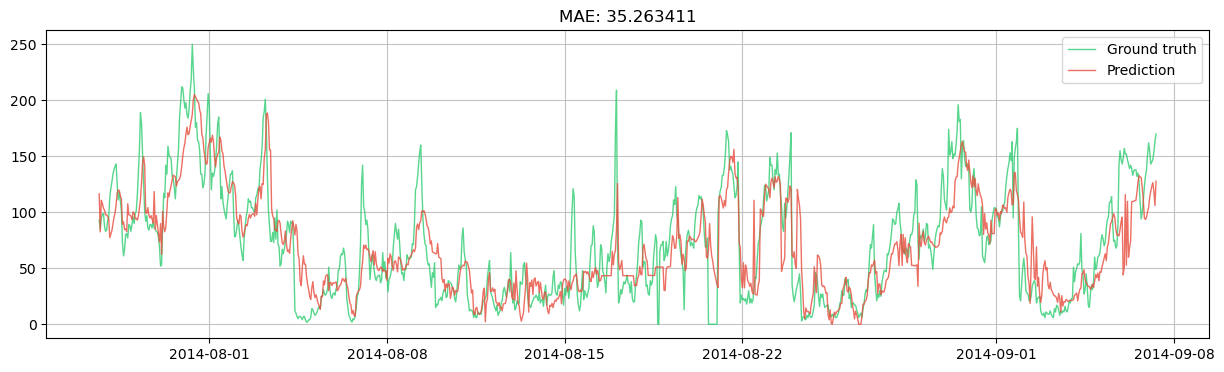

In [59]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})

model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor(grace_period = 250,  drift_detector=drift.ADWIN())


a = evaluate_model(model, data_stream, xlim=1000)

## 7. Results and Conclusions 
Together with notebook presentation max. 2 points. 
* Oral presentation 2 points.